In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [2]:
df = pd.read_csv('Sales_Data_Final.csv')

In [3]:
df.head()

,customer_id,purchase_date,product_id,amount_spent,price_per_item,number_of_items
0,CUST_0055,2023-08-14,PROD_034,196,98,2
1,CUST_0031,2023-11-20,PROD_041,30,6,5
2,CUST_0023,2023-10-29,PROD_024,147,49,3
3,CUST_0053,2023-12-03,PROD_041,18,6,3
4,CUST_0048,2023-08-14,PROD_033,93,93,1


In [6]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

df['day_of_week'] = df['purchase_date'].dt.dayofweek
df['month'] = df['purchase_date'].dt.month
df['week_of_year'] = df['purchase_date'].dt.isocalendar().week

y = df['number_of_items']
X = df.drop(columns=['number_of_items', 'amount_spent','customer_id'], axis=1)


X = pd.get_dummies(X, columns=['product_id'])
X = X.drop(columns=['purchase_date'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

model_xg = xgb.XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)
model_xg.fit(X_train, y_train)

y_pred = model_xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 1.825162208862824
MAE: 1.5504096314311027


In [20]:
# Function to preprocess new input data
def preprocess_input(purchase_date, product_id):
    input_data = pd.DataFrame({
        'purchase_date': [pd.to_datetime(purchase_date)],
        'product_id': [product_id]
    })
    input_data['day_of_week'] = input_data['purchase_date'].dt.dayofweek
    input_data['month'] = input_data['purchase_date'].dt.month
    input_data['week_of_year'] = input_data['purchase_date'].dt.isocalendar().week
    input_data = input_data.drop(columns=['purchase_date'])
    input_data = pd.get_dummies(input_data, columns=['product_id'])
    input_data = input_data.reindex(columns=X_train.columns, fill_value=0)
    return input_data

def round_items(num):
    if num - int(num) <= 0.5:
        return int(num)
    else:
        return int(num) + 1

In [9]:
# Forecast all products for the month of July
future_dates = pd.date_range(start='2023-07-01', end='2023-07-31')

all_product_ids = X.columns[X.columns.str.startswith('product_id_')].str.replace('product_id_', '').tolist()

predicted_sales = []
for product_id in all_product_ids:
    total_items = 0
    for future_date in future_dates:
        new_input_data = preprocess_input(future_date, product_id)
        prediction = model_xg.predict(new_input_data)
        total_items += round_items(prediction[0])
    predicted_sales.append({'product_id': product_id, 'predicted_number_of_items': total_items})

predicted_sales_df = pd.DataFrame(predicted_sales)
print(predicted_sales_df)

   product_id  predicted_number_of_items
0    PROD_001                        115
1    PROD_002                        120
2    PROD_003                        130
3    PROD_004                        118
4    PROD_005                         97
5    PROD_006                        118
6    PROD_007                        113
7    PROD_008                        116
8    PROD_009                        123
9    PROD_010                        128
10   PROD_011                        110
11   PROD_012                        132
12   PROD_013                        119
13   PROD_014                        153
14   PROD_015                        129
15   PROD_016                        107
16   PROD_017                        101
17   PROD_018                        101
18   PROD_019                        113
19   PROD_020                        116
20   PROD_021                        122
21   PROD_022                        137
22   PROD_023                        126
23   PROD_024   

In [12]:
July_top10 = predicted_sales_df.sort_values(by='predicted_number_of_items', ascending=False).head(10)

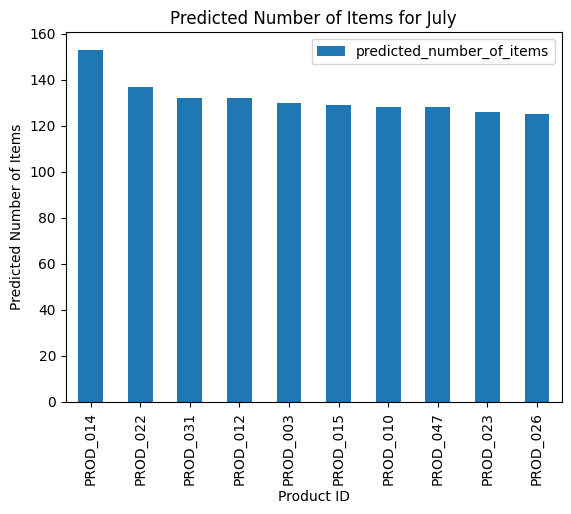

In [17]:
July_top10.plot(x='product_id', y='predicted_number_of_items', kind='bar')
plt.xlabel('Product ID')
plt.ylabel('Predicted Number of Items')
plt.title('Predicted Number of Items for July')
plt.show()

In [15]:
"""Recommendation is to restock these top 10 selling products"""

'Recommendation is to restock these top 10 selling products'

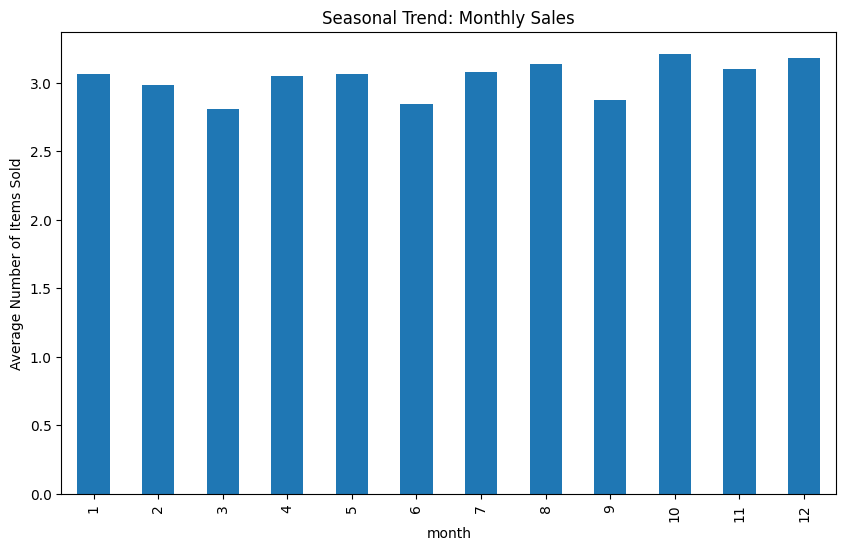

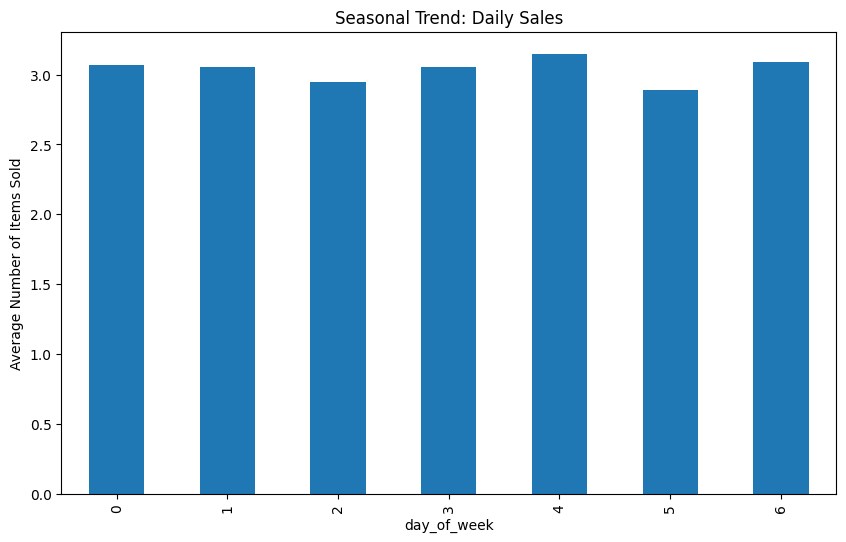

In [19]:
# Seasonal and trend analysis
def plot_seasonality(df, column, title):
    plt.figure(figsize=(10, 6))
    df.groupby(column)['number_of_items'].mean().plot(kind='bar')
    plt.title(title)
    plt.ylabel('Average Number of Items Sold')
    plt.xlabel(column)
    plt.show()

plot_seasonality(df, 'month', 'Seasonal Trend: Monthly Sales')
plot_seasonality(df, 'day_of_week', 'Seasonal Trend: Daily Sales')